In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
def train_distill_ensemble(student_model, teacher_model1, teacher_model2, dataloader, optimizer, T=4.0, alpha=0.7):
    student_model.train()
    teacher_model1.eval()
    teacher_model2.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            outputs1 = teacher_model1(inputs)
            outputs2 = teacher_model2(inputs)
            teacher_outputs = (outputs1 + outputs2) / 2
        student_outputs = student_model(inputs)
        loss = distillation_loss(student_outputs, labels, teacher_outputs, T, alpha)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

num_epochs_ft = 5
num_epochs_small = 10
num_epochs_distill = 10

print("\nPreparing fine-tuned models...")
resnet50 = prepare_finetuned_model('resnet50')
vgg16 = prepare_finetuned_model('vgg16')

criterion = nn.CrossEntropyLoss()

optimizer_resnet = optim.SGD(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer_vgg = optim.SGD(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)


Preparing fine-tuned models...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 49.6MB/s]


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def prepare_finetuned_model(base_model_name='resnet50', num_classes=10):
    if base_model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        for name, param in model.named_parameters():
            if "layer4" in name or "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    elif base_model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
        for name, param in model.named_parameters():
            if "classifier.5" in name or "classifier.6" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
    else:
        raise ValueError("Unsupported model name")
    return model.to(device)


def distillation_loss(y, labels, teacher_scores, T, alpha):
    hard_loss = F.cross_entropy(y, labels)
    soft_loss = F.kl_div(
        F.log_softmax(y / T, dim=1),
        F.softmax(teacher_scores / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    return alpha * hard_loss + (1 - alpha) * soft_loss


def train_distill(student_model, teacher_model, dataloader, optimizer, T=4.0, alpha=0.7):
    student_model.train()
    teacher_model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)
        student_outputs = student_model(inputs)
        loss = distillation_loss(student_outputs, labels, teacher_outputs, T, alpha)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

In [ ]:

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / total, 100. * correct / total

In [ ]:
history = {
    'resnet_train_loss': [], 'resnet_train_acc': [],
    'resnet_val_loss': [], 'resnet_val_acc': [],
    'vgg_train_loss': [], 'vgg_train_acc': [],
    'vgg_val_loss': [], 'vgg_val_acc': [],
    'small_train_loss': [], 'small_train_acc': [],
    'small_val_loss': [], 'small_val_acc': [],
    'distill_train_loss': [], 'distill_train_acc': [],
    'distill_val_loss': [], 'distill_val_acc': [],
    'ens_distill_train_loss': [], 'ens_distill_train_acc': [],
    'ens_distill_val_loss': [], 'ens_distill_val_acc': [],
}

print("\nFine-tuning ResNet50:")
for epoch in range(1, num_epochs_ft + 1):
    train_loss, train_acc = train(resnet50, train_loader, criterion, optimizer_resnet)
    val_loss, val_acc = evaluate(resnet50, test_loader, criterion)
    print(f"Epoch {epoch} ResNet50 Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    history['resnet_train_loss'].append(train_loss)
    history['resnet_train_acc'].append(train_acc)
    history['resnet_val_loss'].append(val_loss)
    history['resnet_val_acc'].append(val_acc)

print("\nFine-tuning VGG16:")
for epoch in range(1, num_epochs_ft + 1):
    train_loss, train_acc = train(vgg16, train_loader, criterion, optimizer_vgg)
    val_loss, val_acc = evaluate(vgg16, test_loader, criterion)
    print(f"Epoch {epoch} VGG16 Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    history['vgg_train_loss'].append(train_loss)
    history['vgg_train_acc'].append(train_acc)
    history['vgg_val_loss'].append(val_loss)
    history['vgg_val_acc'].append(val_acc)

print("\nTraining Small CNN from scratch:")
small_cnn = SmallCNN().to(device)
optimizer_small = optim.Adam(small_cnn.parameters(), lr=0.001)
for epoch in range(1, num_epochs_small + 1):
    train_loss, train_acc = train(small_cnn, train_loader, criterion, optimizer_small)
    val_loss, val_acc = evaluate(small_cnn, test_loader, criterion)
    print(f"Epoch {epoch} SmallCNN Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    history['small_train_loss'].append(train_loss)
    history['small_train_acc'].append(train_acc)
    history['small_val_loss'].append(val_loss)
    history['small_val_acc'].append(val_acc)

print("\nKnowledge distillation from ResNet50 to Small CNN:")
small_cnn_distill = SmallCNN().to(device)
optimizer_distill = optim.Adam(small_cnn_distill.parameters(), lr=0.001)
for epoch in range(1, num_epochs_distill + 1):
    train_loss, train_acc = train_distill(small_cnn_distill, resnet50, train_loader, optimizer_distill)
    val_loss, val_acc = evaluate(small_cnn_distill, test_loader, criterion)
    print(f"Epoch {epoch} Distill Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    history['distill_train_loss'].append(train_loss)
    history['distill_train_acc'].append(train_acc)
    history['distill_val_loss'].append(val_loss)
    history['distill_val_acc'].append(val_acc)

print("\nKnowledge distillation from Ensemble (ResNet50 + VGG16) to Small CNN:")
small_cnn_ens_distill = SmallCNN().to(device)
optimizer_ens_distill = optim.Adam(small_cnn_ens_distill.parameters(), lr=0.001)
for epoch in range(1, num_epochs_distill + 1):
    train_loss, train_acc = train_distill_ensemble(small_cnn_ens_distill, resnet50, vgg16, train_loader, optimizer_ens_distill)
    val_loss, val_acc = evaluate(small_cnn_ens_distill, test_loader, criterion)
    print(f"Epoch {epoch} Ens Distill Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    history['ens_distill_train_loss'].append(train_loss)
    history['ens_distill_train_acc'].append(train_acc)
    history['ens_distill_val_loss'].append(val_loss)
    history['ens_distill_val_acc'].append(val_acc)



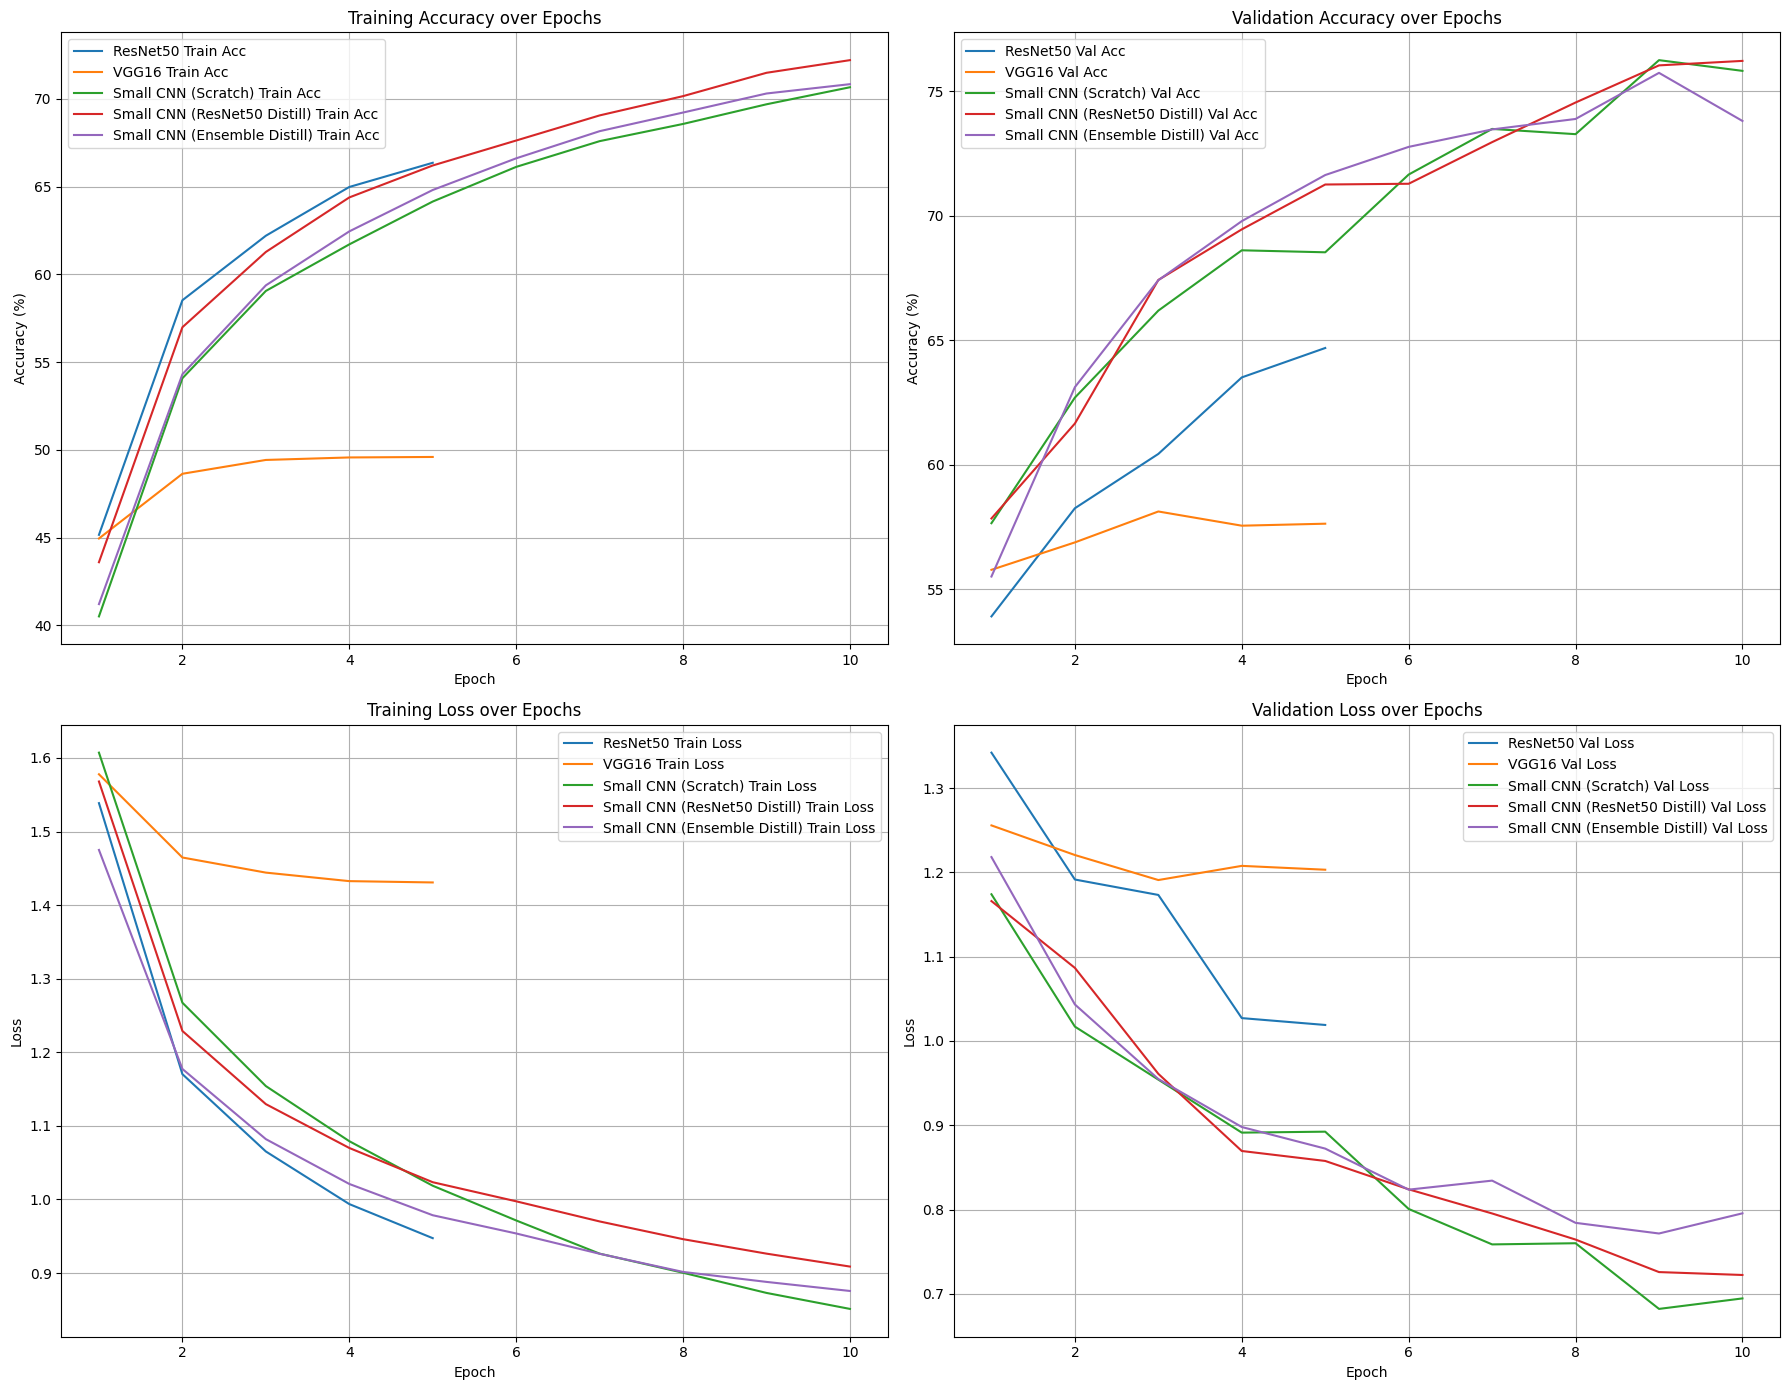

In [ ]:
def plot_combined_metrics(history, num_epochs_ft, num_epochs_small, num_epochs_distill):
    epochs_ft = np.arange(1, num_epochs_ft + 1)
    epochs_small = np.arange(1, num_epochs_small + 1)
    epochs_distill = np.arange(1, num_epochs_distill + 1)
    max_epochs = max(num_epochs_ft, num_epochs_small, num_epochs_distill)
    epochs_all = np.arange(1, max_epochs + 1)


    plt.figure(figsize=(18, 14))

    plt.subplot(2, 2, 1)
    plt.plot(epochs_ft, history['resnet_train_acc'], label='ResNet50 Train Acc')
    plt.plot(epochs_ft, history['vgg_train_acc'], label='VGG16 Train Acc')
    plt.plot(epochs_small, history['small_train_acc'], label='Small CNN (Scratch) Train Acc')
    plt.plot(epochs_distill, history['distill_train_acc'], label='Small CNN (ResNet50 Distill) Train Acc')
    plt.plot(epochs_distill, history['ens_distill_train_acc'], label='Small CNN (Ensemble Distill) Train Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.grid(True)


    plt.subplot(2, 2, 2)
    plt.plot(epochs_ft, history['resnet_val_acc'], label='ResNet50 Val Acc')
    plt.plot(epochs_ft, history['vgg_val_acc'], label='VGG16 Val Acc')
    plt.plot(epochs_small, history['small_val_acc'], label='Small CNN (Scratch) Val Acc')
    plt.plot(epochs_distill, history['distill_val_acc'], label='Small CNN (ResNet50 Distill) Val Acc')
    plt.plot(epochs_distill, history['ens_distill_val_acc'], label='Small CNN (Ensemble Distill) Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)


    plt.subplot(2, 2, 3)
    plt.plot(epochs_ft, history['resnet_train_loss'], label='ResNet50 Train Loss')
    plt.plot(epochs_ft, history['vgg_train_loss'], label='VGG16 Train Loss')
    plt.plot(epochs_small, history['small_train_loss'], label='Small CNN (Scratch) Train Loss')
    plt.plot(epochs_distill, history['distill_train_loss'], label='Small CNN (ResNet50 Distill) Train Loss')
    plt.plot(epochs_distill, history['ens_distill_train_loss'], label='Small CNN (Ensemble Distill) Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(epochs_ft, history['resnet_val_loss'], label='ResNet50 Val Loss')
    plt.plot(epochs_ft, history['vgg_val_loss'], label='VGG16 Val Loss')
    plt.plot(epochs_small, history['small_val_loss'], label='Small CNN (Scratch) Val Loss')
    plt.plot(epochs_distill, history['distill_val_loss'], label='Small CNN (ResNet50 Distill) Val Loss')
    plt.plot(epochs_distill, history['ens_distill_val_loss'], label='Small CNN (Ensemble Distill) Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_combined_metrics(history, num_epochs_ft, num_epochs_small, num_epochs_distill)